## Figures

In this notebook I replicate the analysis and display code for Figs 6 and 7, described in the paper in Secs 4.2.1 (UMAP) and 4.2.2(PCA)

In [14]:
from bs4 import BeautifulSoup

import importlib

from mqdq import rhyme, utils, rhyme_classes, babble
from mqdq import line_analyzer as la

import random
import operator
import bisect
import string
import copy
import re
import scipy as sp
import pandas as pd
import glob
import umap
import os
import subprocess
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Unpickling

For the code that parses the raw XML files and runs the analysis, see the Univariate notebook. In this one we will use the pickled data.

In [2]:
full_results = pd.read_pickle('full_results_42.pkl')
full_results

,work,metre,test,pi,stars,t,f,sum,expected,alternative,binom,conservative,l99,l95,l90,mid,h90,h95,h99
0,Tristia,H,leo,1.423913,***,131,1635,1766,91,greater,0.000033,0.000033,68,77,79,92,108,116,120
1,Tristia,H,slant leo,1.057971,,73,1693,1766,0,None,1.000000,1.000000,48,56,59,69,83,86,94
2,Tristia,H,aa 0,1.423729,***,84,1681,1765,58,greater,0.000630,0.000630,42,43,45,59,71,73,74
3,Tristia,H,axa 0,1.539683,***,97,1668,1765,61,greater,0.000007,0.000007,45,49,51,63,76,78,86
4,Tristia,H,axxa 0,1.203390,*,71,1693,1764,58,greater,0.049878,0.049878,39,45,46,59,69,71,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,Hor. Sat.,H,axa -2,0.898734,,142,1968,2110,150,less,0.254738,0.254738,131,134,136,158,179,184,201
1956,Hor. Sat.,H,axxa -2,1.019108,,160,1949,2109,150,greater,0.216765,0.216765,134,136,137,157,170,182,199
1957,Hor. Sat.,H,aa mid,1.094737,,104,2007,2111,93,greater,0.132339,0.132339,71,79,82,95,108,110,112
1958,Hor. Sat.,H,axa mid,1.053191,,99,2011,2110,93,greater,0.273025,0.273025,71,76,79,94,110,111,113


## Calculate the columns for rhyme strength and rhyme amount

Described in the paper in Sec. 3.7

In [4]:
# First we create two scoring config dicts, one which weights only the score and one which weights only the count

strength = {
    "ult_count": 0,
    "ult_score": 1.0,
    "penult_count": 0,
    "penult_score": 1.0,
    "ante_count": 0,
    "ante_score": 1.0,
    "mid_count": 0,
    "mid_score": 1.0,
    "score_bias": 1,
    "score_exponent": 3.0,
}

count = {
    "ult_count": 1.0,
    "ult_score": 0,
    "penult_count": 1.0,
    "penult_score": 0,
    "ante_count": 1.0,
    "ante_score": 0,
    "mid_count": 1.0,
    "mid_score": 0,
    "score_bias": 0.0,
    "score_exponent": 3.0,
}

### Parse the raw XML files

The `full_results` table contains the data that will be pivoted to make 28 columns per work (14 rhyme scoring functions, once for hexameter and once for pentameter--see Sec. 4.2). We will need the raw files themselves to calculate the last two columns.

In [5]:
allbabs = []

tris_bab = babble.Babbler.from_file(*sorted(glob.glob('mqdq/OV-tri*.xml')), name = 'Tristia')
allbabs.append(tris_bab)

tib_babs = babble.multibabs(sorted(glob.glob('mqdq/TIB-ele*.xml')),"Tibullus")
allbabs.extend(tib_babs)

tib_single_bab = babble.Babbler.from_file(*sorted(glob.glob('mqdq/TIB-ele*.xml')),name ="Tibullus")
allbabs.append(tib_single_bab)

cat_soup, cat_ll = utils.slurp('mqdq/CATVLL-carm.xml')
cat64_bab = babble.Babbler(utils.clean(cat_soup('division')[63]('line')), name = "Cat64")
allbabs.append(cat64_bab)

aen_babs = babble.bookbabs('mqdq/VERG-aene.xml', 'Aeneid')
allbabs.extend(aen_babs)

aen_single_bab = babble.Babbler.from_file('mqdq/VERG-aene.xml', name='Aeneid')
allbabs.append(aen_single_bab)

geo_babs = babble.bookbabs('mqdq/VERG-geor.xml', 'Georgics')
allbabs.extend(geo_babs)

geo_single_bab = babble.Babbler.from_file('mqdq/VERG-geor.xml', name='Georgics')
allbabs.append(geo_single_bab)

sat_babs = babble.bookbabs('mqdq/IVV-satu.xml', 'Juv. Sat.')
allbabs.extend(sat_babs)

sat_single_bab = babble.Babbler.from_file('mqdq/IVV-satu.xml', name='Juv. Sat.')
allbabs.append(sat_single_bab)

met_babs = babble.bookbabs('mqdq/OV-meta.xml', 'Metamorphoses')
allbabs.extend(met_babs)

met_single_bab = babble.Babbler.from_file('mqdq/OV-meta.xml', name='Metamorphoses')
allbabs.append(met_single_bab)

puni_babs = babble.bookbabs('mqdq/SIL-puni.xml', 'Punica')
allbabs.extend(puni_babs)

puni_single_bab = babble.Babbler.from_file('mqdq/SIL-puni.xml', name='Punica')
allbabs.append(puni_single_bab)

theb_babs = babble.bookbabs('mqdq/STAT-theb.xml', 'Thebaid')
allbabs.extend(theb_babs)

theb_single_bab = babble.Babbler.from_file('mqdq/STAT-theb.xml', name='Thebaid')
allbabs.append(theb_single_bab)

phars_babs = babble.bookbabs('mqdq/LVCAN-phar.xml', 'Pharsalia')
allbabs.extend(phars_babs)

phars_single_bab = babble.Babbler.from_file('mqdq/LVCAN-phar.xml', name='Pharsalia')
allbabs.append(phars_single_bab)

prop_babs = babble.multibabs(sorted(glob.glob('mqdq/PROP-ele*.xml')),"Propertius")
allbabs.extend(prop_babs)

prop_single_bab = babble.Babbler.from_file(*sorted(glob.glob('mqdq/PROP-ele*.xml')),name ="Propertius")
allbabs.append(prop_single_bab)

ep_bab = babble.Babbler.from_file('mqdq/OV-epis.xml', name="Heroides")
allbabs.append(ep_bab)

aram_bab = babble.Babbler.from_file('mqdq/OV-aram.xml', name="Ars")
allbabs.append(aram_bab)

fast_bab = babble.Babbler.from_file('mqdq/OV-fast.xml', name="Fasti")
allbabs.append(fast_bab)

arg_babs = babble.bookbabs('mqdq/VAL_FL-argo.xml', 'Argonautica')
allbabs.extend(arg_babs)

arg_single_bab = babble.Babbler.from_file('mqdq/VAL_FL-argo.xml', name='Argonautica')
allbabs.append(arg_single_bab)

rena_babs = babble.bookbabs('mqdq/LVCR-rena.xml', 'DRN')
allbabs.extend(rena_babs)

rena_single_bab = babble.Babbler.from_file('mqdq/LVCR-rena.xml', name='DRN')
allbabs.append(rena_single_bab)

apot_bab = babble.Babbler.from_file('mqdq/PRVD-apot.xml', name='Apotheosis')
allbabs.append(apot_bab)

hamart_bab = babble.Babbler.from_file('mqdq/PRVD-hama.xml', name='Hamartigenia')
allbabs.append(hamart_bab)

psych_bab = babble.Babbler.from_file('mqdq/PRVD-psyc.xml', name='Psychomachia')
allbabs.append(psych_bab)

horsat_babs = babble.multibabs(sorted(glob.glob('mqdq/HOR-sat*.xml')),"Hor. Sat.")
allbabs.extend(horsat_babs)

horsat_single_bab = babble.Babbler.from_file(*sorted(glob.glob('mqdq/HOR-sat*.xml')),name ="Hor. Sat.")
allbabs.append(horsat_single_bab)

### Run the custom scoring functions

For each work (including the smaller 'by book' works) we take global scores, mean per line, using the two custom scoring dicts above.

In [12]:
rhyme_strength = []
for b in allbabs:
    cl = copy.copy(b._syl_source())
    cl.colorlink()
    rhyme_strength.append(cl.score(config=strength))

rhyme_amount = []
for b in allbabs:
    cl = copy.copy(b._syl_source())
    cl.colorlink()
    rhyme_amount.append(cl.score(config=count))


In [17]:
# z-scale the global columns for rhyme amount and rhyme strength.
# Without this step they dominate the visualisation.

ra = pd.DataFrame(rhyme_amount)
ra = StandardScaler().fit_transform(ra)
rs = pd.DataFrame(rhyme_strength)
rs = StandardScaler().fit_transform(rs)

In [10]:
# The full_results frame is concatenated, but for this operation we need it
# back as a list of dataframes by work, because each 14 row frame gets pivoted
# to make a 28 column vector.

dfs = [v for k,v in full_results.groupby('work', sort=False)]

In [11]:
vecs = [babble._pivot(x) for x in dfs]
vecs_df = pd.concat(vecs)
vecs_df

,H-aa -1,H-aa -2,H-aa 0,H-aa mid,H-axa -1,H-axa -2,H-axa 0,H-axa mid,H-axxa -1,H-axxa -2,...,P-axa -1,P-axa -2,P-axa 0,P-axa mid,P-axxa -1,P-axxa -2,P-axxa 0,P-axxa mid,P-leo,P-slant leo
work,,,,,,,,,,,,,,,,,,,,,
Tristia,1.023077,1.084211,1.423729,1.064516,1.007246,1.036585,1.539683,1.151163,0.984496,1.141361,...,1.030303,1.049844,1.287879,0.962617,0.891473,0.942708,0.896552,1.021505,2.051282,1.380435
Tibullus 1,1.037037,1.080000,2.545455,0.913043,1.027027,1.047619,2.533333,0.960000,0.821429,1.220000,...,0.909091,0.977528,1.266667,1.242424,0.769231,1.100000,1.400000,1.000000,1.807692,1.052632
Tibullus 2,1.125000,1.040000,1.666667,0.923077,0.857143,1.181818,1.500000,1.000000,0.705882,1.153846,...,1.050000,0.926829,0.875000,1.294118,0.888889,1.160000,1.000000,1.083333,2.062500,1.400000
Tibullus,1.045455,1.094595,2.235294,0.942857,0.949153,1.111111,2.272727,1.028571,0.818182,1.213333,...,1.000000,0.954198,1.130435,1.235294,0.818182,1.135135,1.250000,1.028571,2.000000,1.172414
Cat64,1.035714,0.978261,1.461538,0.916667,0.571429,1.043478,1.000000,1.480000,0.900000,1.088889,...,0.571429,1.043478,1.000000,1.480000,0.900000,1.088889,1.000000,0.920000,1.541667,1.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hamartigenia,1.076923,1.144578,0.785714,1.000000,1.151515,0.914634,1.285714,1.187500,0.954545,1.048193,...,1.151515,0.914634,1.285714,1.187500,0.954545,1.048193,1.296296,0.875000,2.022727,1.333333
Psychomachia,1.014925,0.917647,0.703704,0.891304,0.954545,1.023256,1.481481,1.022222,1.238806,0.953488,...,0.954545,1.023256,1.481481,1.022222,1.238806,0.953488,1.035714,1.066667,1.413043,0.939394
Hor. Sat. 1,1.084746,1.012987,1.357143,1.000000,1.210526,0.947368,1.250000,0.866667,1.189655,1.160000,...,1.210526,0.947368,1.250000,0.866667,1.189655,1.160000,0.964286,1.000000,1.260870,1.090909


In [33]:
# tack the last two columns onto the df.

# The final vectors have 30 components.

vecs_df['ra'] = ra
vecs_df['rs'] = rs
vecs_df

,H-aa -1,H-aa -2,H-aa 0,H-aa mid,H-axa -1,H-axa -2,H-axa 0,H-axa mid,H-axxa -1,H-axxa -2,...,P-axa 0,P-axa mid,P-axxa -1,P-axxa -2,P-axxa 0,P-axxa mid,P-leo,P-slant leo,ra,rs
work,,,,,,,,,,,,,,,,,,,,,
Tristia,1.023077,1.084211,1.423729,1.064516,1.007246,1.036585,1.539683,1.151163,0.984496,1.141361,...,1.287879,0.962617,0.891473,0.942708,0.896552,1.021505,2.051282,1.380435,1.282169,1.239891
Tibullus 1,1.037037,1.080000,2.545455,0.913043,1.027027,1.047619,2.533333,0.960000,0.821429,1.220000,...,1.266667,1.242424,0.769231,1.100000,1.400000,1.000000,1.807692,1.052632,2.001723,1.950451
Tibullus 2,1.125000,1.040000,1.666667,0.923077,0.857143,1.181818,1.500000,1.000000,0.705882,1.153846,...,0.875000,1.294118,0.888889,1.160000,1.000000,1.083333,2.062500,1.400000,1.811147,1.691529
Tibullus,1.045455,1.094595,2.235294,0.942857,0.949153,1.111111,2.272727,1.028571,0.818182,1.213333,...,1.130435,1.235294,0.818182,1.135135,1.250000,1.028571,2.000000,1.172414,1.943020,1.884326
Cat64,1.035714,0.978261,1.461538,0.916667,0.571429,1.043478,1.000000,1.480000,0.900000,1.088889,...,1.000000,1.480000,0.900000,1.088889,1.000000,0.920000,1.541667,1.222222,0.695816,0.378722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hamartigenia,1.076923,1.144578,0.785714,1.000000,1.151515,0.914634,1.285714,1.187500,0.954545,1.048193,...,1.285714,1.187500,0.954545,1.048193,1.296296,0.875000,2.022727,1.333333,-0.110831,-0.160320
Psychomachia,1.014925,0.917647,0.703704,0.891304,0.954545,1.023256,1.481481,1.022222,1.238806,0.953488,...,1.481481,1.022222,1.238806,0.953488,1.035714,1.066667,1.413043,0.939394,-0.570644,-0.461375
Hor. Sat. 1,1.084746,1.012987,1.357143,1.000000,1.210526,0.947368,1.250000,0.866667,1.189655,1.160000,...,1.250000,0.866667,1.189655,1.160000,0.964286,1.000000,1.260870,1.090909,-1.563148,-1.455854


## Figure 6 - a UMAP visualisation of the data

In [19]:
# Now we need the size (in lines) for each work, since the UMAP points are scaled by size

sizes = [len(x.raw_source) for x in allbabs]

In [34]:
# Do the actual UMAP projection.

umap_results = pd.DataFrame(vecs_df.index)
umapper = umap.UMAP(
    n_neighbors=15,
    # project to 2 dimensions
    n_components=2,
    metric='euclidean',
    # UMAP figures change with every run if not seeded
    random_state=2020
)

u = umapper.fit_transform(vecs_df)
umap_results['X'], umap_results['Y'] =  u[:,0], u[:,1]

# Now we have an X-Y coordinate applied to every chunk
# We will visualise with ggplot instead of using the UMAP tools.
# Add an author column for colouring and a size column for sizing.
umap_results['author'] = umap_results.work.str.replace('\s[0-9]+', '') # will be used for colouring
umap_results['size'] = sizes
umap_results

,work,X,Y,author,size
0,Tristia,-0.167965,0.621651,Tristia,3532
1,Tibullus 1,-0.447635,0.145683,Tibullus,811
2,Tibullus 2,-0.661863,0.302349,Tibullus,430
3,Tibullus,-0.622901,0.041353,Tibullus,1241
4,Cat64,-0.548712,2.497068,Cat64,407
...,...,...,...,...,...
123,Hamartigenia,-0.841568,4.166424,Hamartigenia,966
124,Psychomachia,0.575870,7.415553,Psychomachia,914
125,Hor. Sat. 1,1.374185,8.509520,Hor. Sat.,1030
126,Hor. Sat. 2,1.027656,8.194964,Hor. Sat.,1083


In [22]:
%load_ext rpy2.ipython

/Users/ben/silius/silius_env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [23]:
%%capture
%%R

# Setup R stuff...

pacman::p_load(
    tidyverse,ggsci,ggpubr,ggrepel, extrafont,RColorBrewer, svglite
)

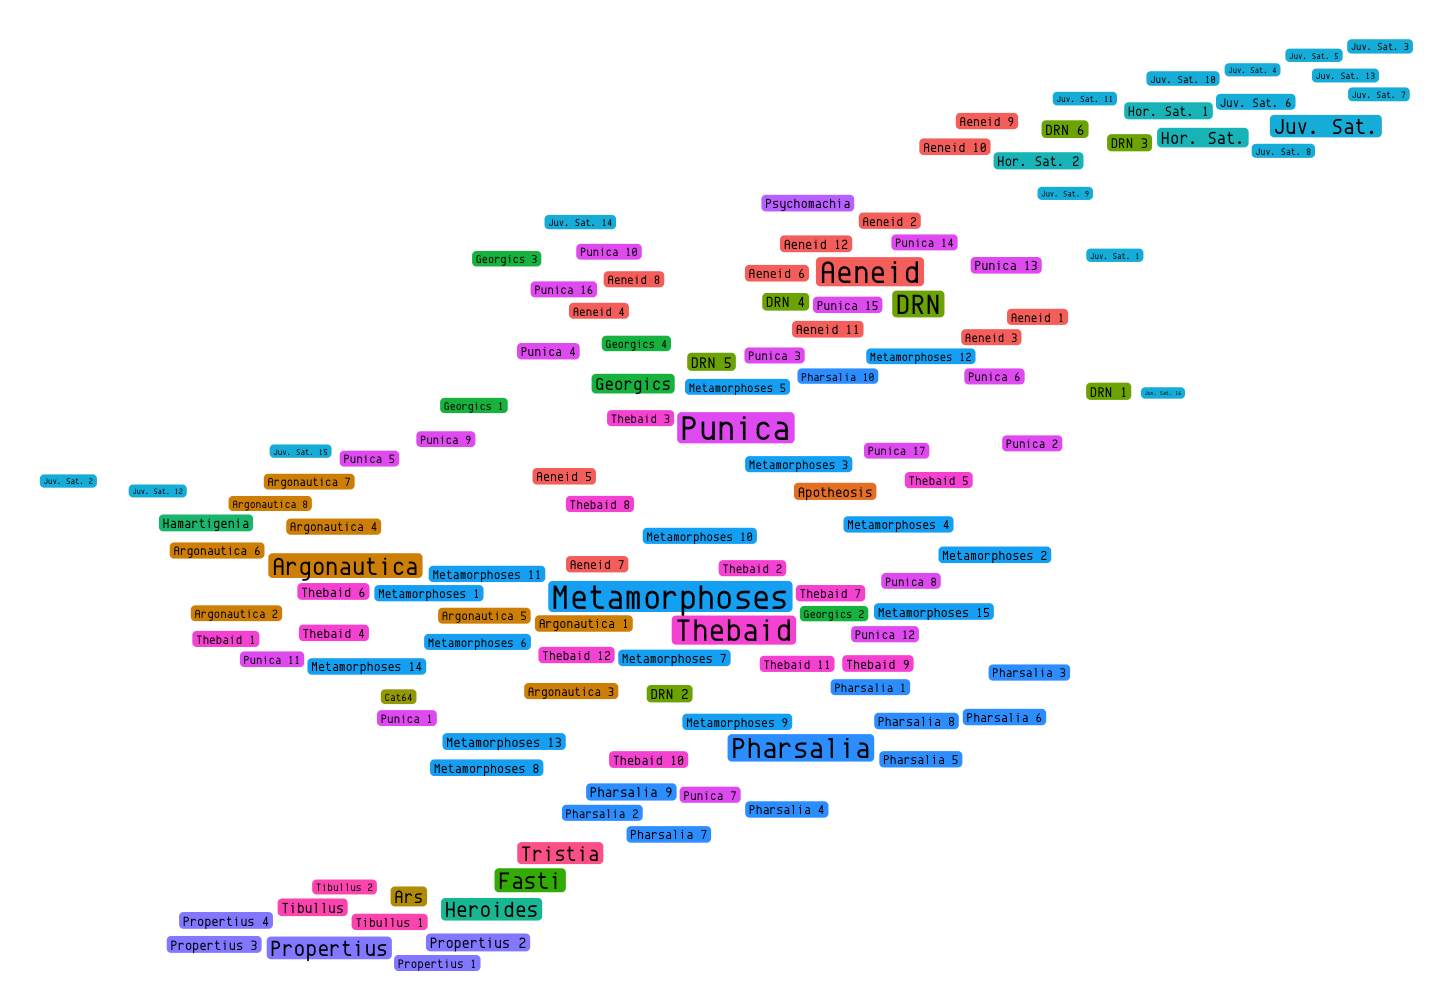

In [42]:
%%R -i umap_results -h 7 -w 10 -u in -r 144

ggplot(data=umap_results,aes(x=X, y=Y, fill=author, label=work, size=size)) +
geom_label_repel(
    family="Envy Code R",
    color='black',
    label.padding = unit(0.13, "lines"),
    box.padding=0.05,
    segment.size=0,
    label.size=NA,
    alpha=1.0,
    max.iter=10000,
) +

theme_minimal() +
theme(plot.title = element_text(margin = margin(b = 50))) +
guides(fill = guide_legend(ncol=2,override.aes = aes(label = ""))) +
theme(legend.position = 'none', legend.title=element_blank()) +
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
theme(text = element_text(size=11, family="Envy Code R"), panel.grid.minor=element_blank(), panel.grid.major=element_blank())

# fn <- "../rhyme_umap.pdf"
# ggsave(fn, dpi=600, height=7, width=10, device=cairo_pdf)
# embed_fonts(fn)

## Figure 7 - a PCA Visualisation of the data

In [32]:
# just to make things slightly easier in the plot

ar_vecs_y = vecs_df.index
ar_vecs_auth = umap_results['author']

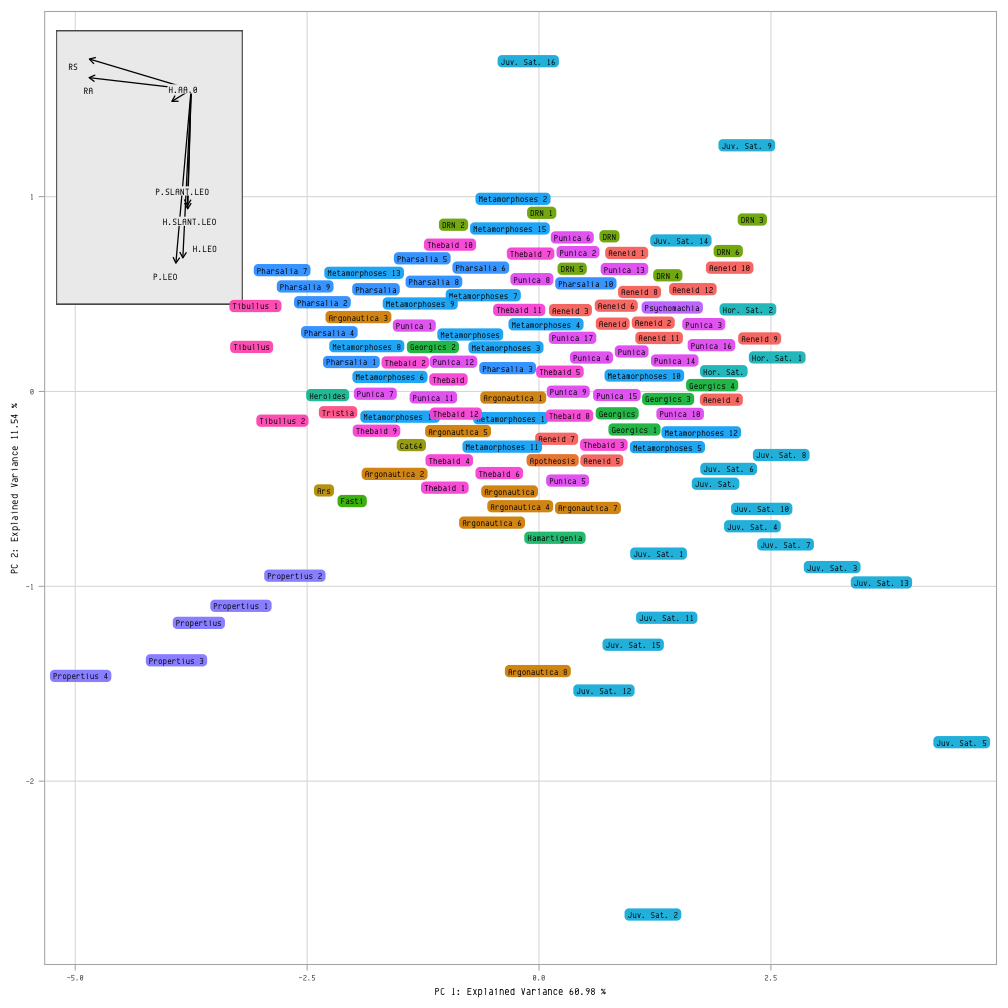

In [44]:
%%R -i vecs_df,ar_vecs_y,ar_vecs_auth -h 7 -w 7 -u in -r 144

# Do PCA
PCA <- prcomp(vecs_df)
vecs_df['Author'] <- ar_vecs_y

# Extract PC axes
PCAvalues <- data.frame(Author = ar_vecs_y, PCA$x)

# Extract loadings of the variables
PCAloadings <- data.frame(Variables = rownames(PCA$rotation), PCA$rotation)

# This is all used to plot the relative directions of the 'real' features
# in the PC axis coordinates (the 'compass rose' inset)

PCAloadings <- 
  PCAloadings %>% 
  mutate(
    Angle = ((180/pi) * atan(PC2/PC1)),
    Offset = ((-2 * sign(PC1))/1.8), 
    length = PC1^2 + PC2^2
  )

magnification <- 1.6
arrow_cutoff <- 0.018 # by experimentation (don't want the rose too cluttered)
x_origin <- -3.75
y_origin <- 1.55
pca_summ <- summary(PCA)

# Plot
ggplot(PCAvalues, aes(x = PC1, y = PC2)) +
geom_rect(xmin=-5.2, xmax=-3.2, ymin = 0.45, ymax=1.85, color='grey35', fill='grey93', size=0.2) + 
# Direction lines for the 'biggest' contributors to PC1 & 2
# offset to make a 'compass rose' style inset
geom_segment(
aes(x = x_origin, y = y_origin, 
    xend = ((PC1*magnification) + x_origin), 
    yend = ((PC2*magnification) + y_origin)),
data = PCAloadings %>% filter(length >= arrow_cutoff),
color = "black", size=0.3,
arrow = arrow(length = unit(0.007, "npc"))
) + 
# Labels for the direction lines
geom_label_repel(
aes(label = str_to_upper(Variables), 
    x = (PC1  * (magnification) + x_origin), 
    y = (PC2  * (magnification) + y_origin)
),
color = "black",
size = 1.6, 
data = PCAloadings %>% filter(length >= arrow_cutoff),
segment.size=NA,
label.size=NA,
label.padding=0.05,
fill='grey93',
family = "Envy Code R"
) + 

# Now plot the actual data points as labels. This can move them around quite a lot
# but the general impression is what we're looking for, here.
geom_label_repel(
    size = 1.5, 
    box.padding=0.02, 
    label.padding=0.11, 
    label.size=NA,
    family="Envy Code R",
    alpha=0.95,
    segment.size=NA,
    label=PCAvalues$Author,
    aes(fill=ar_vecs_auth)
) +
theme_light() +
theme(text = element_text(size=5, family="Envy Code R", color='black'), panel.grid.minor=element_blank(), legend.title=element_blank(), legend.position='none') +
labs(
    x=paste("PC 1: Explained Variance", round(pca_summ$importance[2,1]*100,2), "%"),
    y=paste("PC 2: Explained Variance", round(pca_summ$importance[2,2]*100,2), "%")
)

# fn <- "../rhyme_pca_arrows.pdf"
# ggsave(fn, dpi=600, height=7, width=7)
# embed_fonts(fn)